In [3]:
# Imports
from os import makedirs
from os.path import join
import pickle
import numpy as np
rng_seed = 399
np.random.seed(rng_seed)
from scipy.spatial.distance import pdist, cdist, squareform
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import sys
sys.path.append("..")

from sklearn.model_selection import ParameterGrid
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import pairwise_distances

from utils import get_model_checkpoint_filepaths

In [2]:
# Get last word embeddings from training
checkpoint_filepaths_dict = get_model_checkpoint_filepaths(
    output_dir="../output/word2vec_training/17-Oct-2020_01-00-56",
    model_name="word2vec",
    dataset_name="enwiki",
)
last_embedding_weights_filepath = checkpoint_filepaths_dict["intermediate_embedding_weight_filepaths"][-1]
last_embedding_weights = np.load(last_embedding_weights_filepath, mmap_mode="r").astype(np.float64)

In [8]:
def cluster_hyperparameters_search(
    clusterers: list,
    clusterer_names: list,
    clusterer_hyperparam_grids: list,
    vocab_size: int,
    word_embeddings: np.ndarray,
    output_dir: str = None,
    model_name: str = None,
    dataset_name: str = None,
):
    """
    TODO: Docs
    """
    # Ensure output directory exists
    makedirs(output_dir, exist_ok=True)
    
    # Default to all words if -1
    if vocab_size == -1:
        vocab_size = len(word_embeddings)
    
    # Only fit/evaluate on max `vocab_size` words.
    word_embeddings_fit = word_embeddings[:vocab_size]
    word_embeddings_pairwise_dists = pairwise_distances(word_embeddings_fit)
    
    # Fit and predict cluster labels
    cluster_labels = {}
    for clusterer, clusterer_name, hyperparam_grid in zip(clusterers, clusterer_names, clusterer_hyperparam_grids):
        print(f"-- Fitting and predicting cluster labels using {clusterer_name} --")
        cluster_labels[clusterer_name] = {
            "labels": [],
            "metric_values": [],
            "best_labels_idx": -1
        }
        clusterer_metric_values = []
        for hyperparams in tqdm(hyperparam_grid):
            cls = clusterer(**hyperparams)
            cluster_labels_pred = cls.fit_predict(word_embeddings_fit)
            cluster_labels[clusterer_name]["labels"].append(cluster_labels_pred)
            cluster_metric_value = silhouette_score(word_embeddings_pairwise_dists, cluster_labels_pred, metric="precomputed")
            clusterer_metric_values.append(cluster_metric_value)
        
        cluster_labels[clusterer_name]["metric_values"] = clusterer_metric_values
        cluster_labels[clusterer_name]["best_labels_idx"] = np.argmax(clusterer_metric_values)
        
    
    # Save to output dir
    if output_dir is not None and model_name is not None and dataset_name is not None:
        output_path = join(output_dir, f"{model_name}-{dataset_name}-k-means_labels.pkl")
        with open(output_path, "wb") as file:
            pickle.dump(cluster_labels, file)
    
    return cluster_labels

In [9]:
ks = [10, 50, 100, 150, 200, 300, 400, 500, 750, 1000, 1500, 2000]
pred_cluster_labels = cluster_hyperparameters_search(
    clusterers=[
        KMeans
    ],
    clusterer_names=[
        "K-means clustering"
    ],
    clusterer_hyperparam_grids=[
        ParameterGrid({"n_clusters": ks, "random_state": [rng_seed]})
    ],
    vocab_size=10000,
    word_embeddings=last_embedding_weights,
    output_dir="../output/word2vec_cluster_analysis",
    model_name="word2vec",
    dataset_name="enwiki"
)

-- Fitting and predicting cluster labels using K-means clustering --


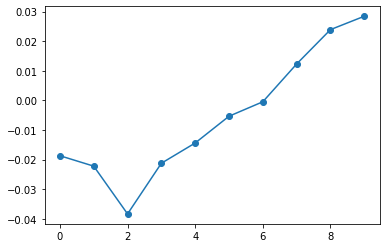

In [10]:
silhouette_scores = pred_cluster_labels["K-means clustering"]["metric_values"]
xs = range(10)

plt.scatter(xs, silhouette_scores)
plt.plot(xs, silhouette_scores)
plt.show()

In [ ]:
# TODO: Compute cluster size ratios (maximum cluster size / minimum cluster size)